In [1]:
import sys
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, clear_output, HTML, Javascript
display(HTML("<style>.container { width:100% !important; }</style>"))

In [130]:
import pandas as pd
import numpy as np

df = pd.read_csv("../experiments/data/raw/DIJA-2006-2018.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

In [131]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [132]:
from hedgepy.core import HedgeFrame

hf = HedgeFrame(df, 'Name')
_90d_dcor_network = hf.dcor(rolling_window=90).network().frame

In [149]:
import networkx as nx

def average_communicability_betweenness(G):
    cbc = nx.communicability_betweenness_centrality(G)
    average_cbc = np.mean(list(cbc.values()))
    return average_cbc

def average_degree_centrality(G):
    dc = nx.degree_centrality(G)
    avg_dc = np.mean(list(dc.values()))
    return avg_dc

def average_eigenvector_centrality(G):
    ec = nx.eigenvector_centrality(G, weight='weight')
    avg_ec = np.mean(list(ec.values()))
    return avg_ec

# nx_time_series = {
#     timestamp: nx.average_clustering(dcor_network, weight='weight') 
#      for timestamp, dcor_network in _90d_dcor_network.items()
# }

nx_time_series = {
    timestamp: average_eigenvector_centrality(dcor_network) 
     for timestamp, dcor_network in _90d_dcor_network.items()
}
    
df_clustering = pd.DataFrame.from_dict(nx_time_series, orient='index')\
    .rename(columns={0: '90d_global_clustering_coefficient'})

In [70]:
# df_clustering.to_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-eigenvector-0.33corr-thresh.csv')

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

In [10]:
df_dija_index = pd.read_csv('../experiments/data/raw/DIJA-index-2006-2018.csv')

In [11]:
df_dija_index['Date'] = pd.to_datetime(df_dija_index['Date'])

In [12]:
df_dija_index.set_index('Date', inplace=True)

In [209]:
dft = pd.read_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-eigenvector-0.33corr-thresh.csv')
dft = dft.rename(columns={'Unnamed: 0': 'Date'})
dft['Date'] = pd.to_datetime(dft['Date'])
dft.set_index('Date', inplace=True)

In [28]:
test = df_dija_index['Close'].pct_change().rolling(30).std()

Text(0, 0.5, 'DIJA Index')

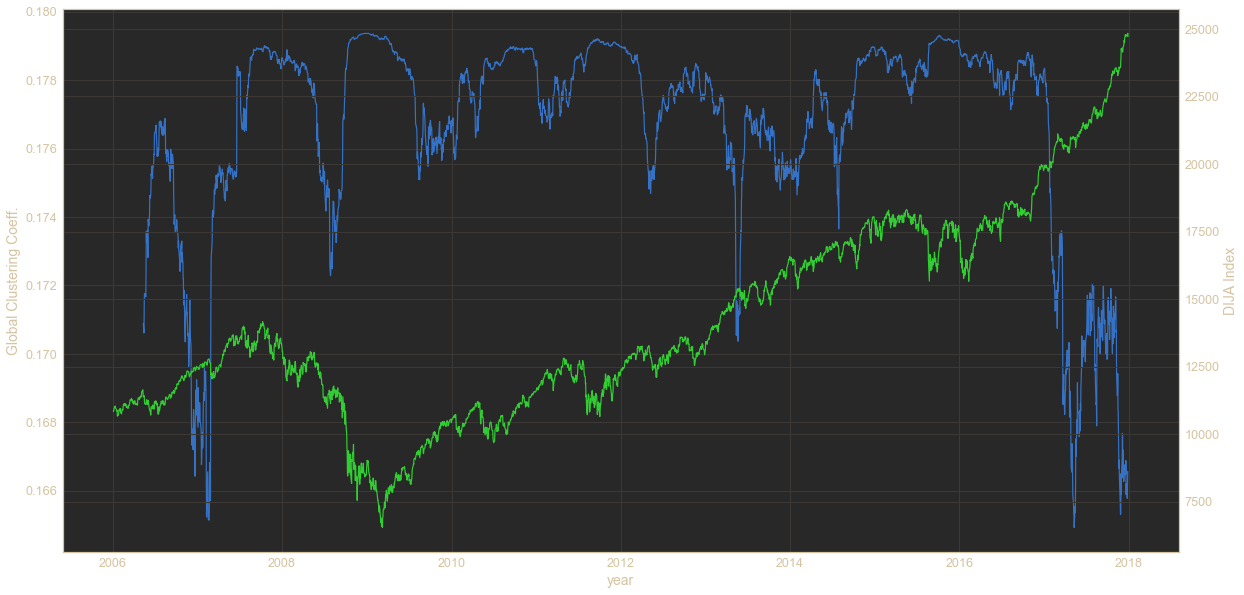

In [210]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft)
ax.set_xlabel("year", fontsize=14)
ax.set_ylabel("Global Clustering Coeff.", fontsize=14)

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)

In [195]:
dft['90d_global_clustering_coefficient'].corr(df_dija_index['Close'])

-0.5187878545893508

In [152]:
dft = df_clustering

In [205]:
dft_pos = dft.pct_change()[dft.pct_change()['90d_global_clustering_coefficient'] >=0]

In [335]:
# dft_pos.columns = ['crisis_coeff']
# dft_pos.dropna(inplace=True)

In [211]:
dft['crisis_coeff'] = dft[['90d_global_clustering_coefficient']].pct_change()

In [214]:
dft.dropna(inplace=True)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import math

def optimize_OneClassSVM(X, n):
    print('searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    return opt_nu, opt_gamma

In [215]:
data = dft[['crisis_coeff']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled).dropna()

opt_nu, opt_gamma = optimize_OneClassSVM(data, n=10)

searching for optimal hyperparameters...


In [169]:
opt_nu

0.00445

In [170]:
opt_gamma

0.00011200000000000001

In [216]:
#train OneClassSVM
model = OneClassSVM(nu=opt_nu, kernel="rbf", gamma=opt_gamma)
model.fit(data)
anomalies = pd.Series(model.predict(data), index=dft.index)

In [217]:
dft['anomaly'] = anomalies

2020-04-26 22:57:27,749 [23208] WARNING  matplotlib.legend:1282: [JupyterRequire] No handles with labels found to put in legend.


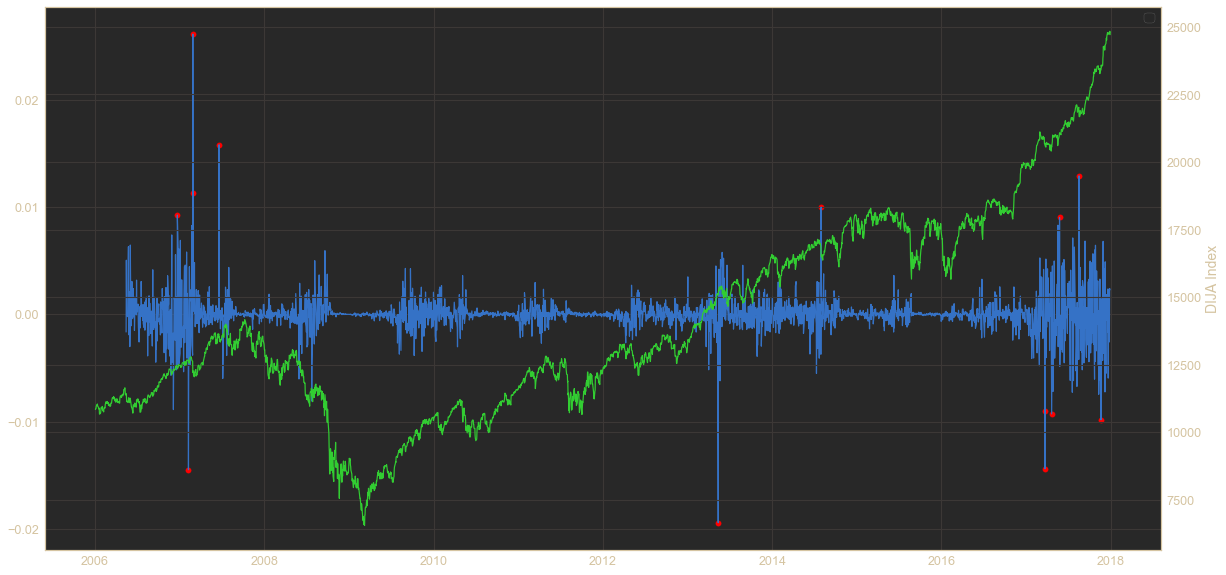

In [218]:
a = dft.loc[dft['anomaly'] == -1, ['crisis_coeff']]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['crisis_coeff'], label='Normal')
ax.scatter(a.index, a['crisis_coeff'], color='red', label='Anomaly')

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
plt.legend()

In [219]:
dft[(dft['anomaly'] == -1) & (dft['crisis_coeff'] > 0)] 

,90d_global_clustering_coefficient,crisis_coeff,anomaly
Date,,,
2006-12-22,0.167967,0.009243,-1
2007-02-27,0.170039,0.026110,-1
2007-02-28,0.171955,0.011266,-1
2007-06-20,0.178195,0.015793,-1
2014-07-31,0.175383,0.009981,-1
2017-05-25,0.169158,0.009026,-1
2017-08-17,0.170062,0.012898,-1


In [179]:
import ipyhc as hc

dija_index_series = hc.build.series(df_dija_index[['Close']])
df_clustering_series = hc.build.series(dft[['90d_global_clustering_coefficient']])

In [180]:
df_clustering_series[0]['yAxis'] = 1

In [181]:
options = {
    'credits': {'enabled': True,
                'text': 'Source: XXX Flow Strategy & Solutions.',
                'href': 'http://www.example.com'},
    'exporting': {'enabled': True},
    'chart': {'zoomType': 'xy'},
    'plotOptions': {'series': {'compare': 'percent'}},
    'legend': {'enabled': True,
               'layout': 'horizontal',
               'align': 'center',
               'maxHeight': 100},
    'tooltip': {'enabled': True,
                'valueDecimals': 5,
                'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.change}%)<br/>',
                'positioner': "function(labelWidth, labelHeight, point) {\n    var roundUp100 = function(d) { return 100*Math.floor(d/100); },\n        labelWidth = roundUp100(labelWidth),\n        chart = window.charts['__uuid__'];\n\n    var tooltipX, tooltipY;\n        var testX = (point.plotX + labelWidth * 0.7 > chart.plotWidth / 2) && (point.plotX - labelWidth * 0.7 < chart.plotWidth / 2);\n        var testY = point.plotY < labelHeight * 0.7;\n\n    if (testX && testY) {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop + chart.plotHeight - labelHeight;\n    } else {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop;\n    }\n\n    return {\n        x: tooltipX,\n        y: tooltipY\n    };\n}\n\n"},
    'title': {'text': 'Time series plotted with HighStock'},
    'subtitle': {'text': 'Transparent access to the underlying js lib'},
    'yAxis': [
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
        },
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
            'title': {
                'text': '% change'
            }
        }
    ],
    'xAxis': {
        'gridLineWidth': 1.0, 
        'gridLineDashStyle': 'Dot'},
}

chart = hc.Chart(height=600, width=1200, stock = True, options = options, data = dija_index_series + df_clustering_series)
chart

Chart(height='600px', stock=True, width='1200px')